# 数据处理
## 数据读取

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
%matplotlib inline

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

## 数据查看

(209, 64, 64, 3)
y = [0], it's a 'non-cat' picture.


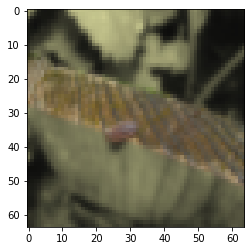

In [3]:
# Example of a picture
print(train_set_x_orig.shape)
index =12
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

## 数据转换

In [4]:
# 转换维度
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
# 标准化自变量
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

train_set_x.shape, train_set_y.shape, test_set_y.shape, train_set_x[0:5,0]

((12288, 209),
 (1, 209),
 (1, 50),
 array([0.06666667, 0.12156863, 0.21960784, 0.08627451, 0.12941176]))

# 模型建立
## 定义sigmoid函数和初始化参数

In [5]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

## 正向传播与反向传播
Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [6]:
#求取参数导数
def propagate(w, b, X, Y):   
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X)+b)   
    cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))                                
    dw =(1/m)*np.dot(X,(A-Y).T)
    db =(1/m)*np.sum(A-Y)
    return  dw ,db, cost

In [7]:
# 参数优化
def optimize(w, b, X, Y, num_iterations, learning_rate):
    costs = [] 
    num=[]
    for i in range(num_iterations):
        dw ,db, cost = propagate(w, b, X, Y)
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
            num.append(i)
        
    return w ,b, costs, num


## 预测函数

In [8]:

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] =0
    return Y_prediction

## 模型汇总

In [9]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5):
    w, b = initialize_with_zeros(X_train.shape[0])     #前面定义的初始化函数
    w ,b, costs,num = optimize(w, b, X_train, Y_train, num_iterations, learning_rate) #前面定义的参数优化
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train =predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    plt.plot(num,costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

## 模型评估

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %


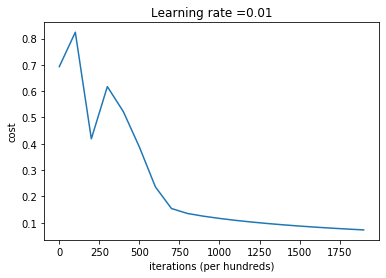

In [10]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.01)

# 实例运用

In [11]:
def pred(image):
    img=Image.open(image)
    adjust_img=img.resize((64,64),Image.BILINEAR)
    a=np.array(adjust_img)
    my_img=a.reshape(a.shape[0]**2*3,1)
    predicted_image = predict(d["w"], d["b"], my_img)
    if predicted_image[0,0]==0:
        print("it's a non-cat picture.")
    else:
        print("it's a catpicture.")    
    plt.imshow(adjust_img)

it's a catpicture.


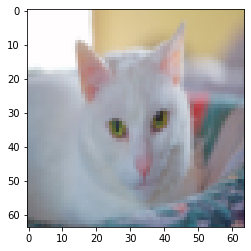

In [17]:
pred('images/my_image2.jpg')